<p style="text-align: center; font-size: 300%"> Computational Finance </p>
<img src="img/ABSlogo.svg" alt="LOGO" style="display:block; margin-left: auto; margin-right: auto; width: 50%;">

# Risk Measures
## Introduction
* The Basel Accords mandate that financial institutions report the risk associated with their positions, so that regulators may check the adequacy of the economic capital as a buffer against market risk.
* Reporting is the form of a *risk measure*, which condenses the risk of a position into a single number.
* Currently, the mandated measure is *Value at Risk*, but there are debates of replacing it with an alternative (*Expected Shortfall*).
* Banks are allowed to use their own, internal models for the computation of VaR, but the adequacy of these models should be *backtested*.


## Value at Risk
* Consider a portfolio with value $V_{PF,t}$ and daily returns $%
R_{PF,t}$.
* Define the one-day Loss on the portfolio as
\begin{equation*}
\$Loss_{t+1}=V_{PF,t}-V_{PF,t+1}.
\end{equation*}
* I will distinguish between the dollar Value at Risk (an amount) and the return Value at Risk (a percentage). When unqualified, I mean the latter.
* The one-day $100p\%$ dollar Value at Risk
$\$VaR_{t+1}^{p}$ is the loss on the portfolio that we we are $100\left(1-p\right) \%$ confident will not be exceeded. The Basel committee requires $p=0.01$.

* The *return Value at risk* $VaR_{t+1}^{p}$ expresses $\$VaR_{t+1}^{p}$ as a percentage of the portfolio value:
\begin{equation*}
VaR_{t+1}^{p}=\frac{\$VaR_{t+1}^{p}}{V_{PF,t}}.
\end{equation*}
* Hence
\begin{equation*}
\Pr (R_{PF,t+1}<-VaR_{t+1}^{p})=p,
\end{equation*}
because
\begin{equation*}
R_{PF,t+1}=-\frac{\$Loss_{t+1}}{V_{PF,t}}.
\end{equation*}

Thus $VaR_{t+1}^{p}$ is minus the $100p$th *percentile*
of the return distribution. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import scipy.stats as stats
a, b, c = -5, 5, stats.norm.ppf(0.05)
x = np.linspace(a, b, 100)
y = stats.norm.pdf(x)
fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(x, y, 'b', linewidth=2)
plt.ylim(ymin=0)
plt.xlim(xmin=a, xmax=b)
Ix = np.linspace(a, c)
Iy = stats.norm.pdf(Ix)
verts = [(a, 0)] + list(zip(Ix, Iy)) + [(c, 0)]
poly = Polygon(verts, facecolor='0.7', edgecolor='0.5')
ax.add_patch(poly)
ax.annotate('$p\%$', xy=(-2, 0.025), xytext=(-3, 0.1),
            arrowprops=dict(width=.5),
            )
plt.xlabel('$R_{PF,t+1}$')
plt.ylabel('$f(R_{PF,t+1})$')

ax.set_xticks([c, 0])
ax.set_xticklabels(['$-VaR_{t+1}^p$', '0'])
ax.set_yticks([])
plt.savefig('img/var.svg')
plt.close()

<img src="img/var.svg" alt="VaR" style="display:block; margin-left: auto; margin-right: auto; width: 80%;">

## Asset Returns: Stylized Facts
* Stylized facts about asset returns include
  * Lack of autocorrelation
  * Leverage effects
  * Heavy tails of returns distribution
  * Volatility clustering
  
* These need to be taken into account when creating VaR forecasts. 


## VaR Methods
### Historical Simulation

* Historical simulation assumes that the distribution of tomorrow's portfolio
returns is well approximated by the empirical distribution (histogram) of
the past $m$ observations $\left\{
R_{PF,t},R_{PF,t-1},\ldots,R_{PF,t+1-m}\right\} $.

* This is as if we draw, with replacement, from the last $m$ returns and use
this to simulate the next day's return distribution.

* The estimator of VaR is given by minus the $100p$th *percentile* (or the $p$th *quantile*) of the sequence of past portfolio returns, i.e., $\widehat{VaR}_{t+1}^{p}=-R_{t+1}^{p}$, where $R_{t+1}^{p}$ is the number such that $100p\%$ of the observations are smaller than $R_{t+1}^{p}$.


* In Python, we can use NumPy's `quantile` method, or the `percentile` function. Below we use `nanpercentile` which ignores that `np.isnan(r[0])==True` (Hilpisch uses scoreatpercentile, but that is is deprecated).

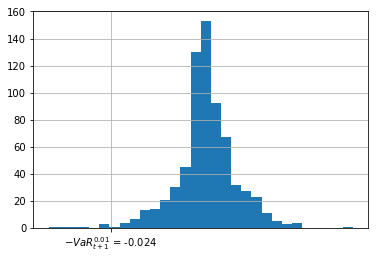

In [2]:
import pandas as pd
import pandas_datareader.data as web
from datetime import timedelta
%matplotlib inline
m=1000 #~4 trading years
p=web.DataReader("^GSPC", 'yahoo', end=pd.datetime.today(), start=pd.datetime.today()-timedelta(days=1000))['Adj Close']
r=np.log(p)-np.log(p).shift(1)
VaR=-r.quantile(.01) #Alternatively, VaR=np.nanpercentile(r,1)
ax=r.hist(bins=30) #histogram with 30 bins
ax.set_xticks([-VaR]);
ax.set_xticklabels(['$-VaR_{t+1}^{0.01}$ = -%4.3f' %VaR]); #4.3f means 4 digits, of which 3 decimals

* Problem: Last year(s) of data not necessarily representative for the next few days (e.g. because of volatility clustering).
* Exacerbated by the fact that a large $m$ is required to compute $1\%$ VaR with any degree of precision (only 1% of the data are really used).

In [3]:
import pandas as pd
start = pd.datetime(2010, 1, 1)
end = pd.datetime.today()
aapl = web.DataReader("AAPL", 'yahoo', start, end)
ret=np.log(aapl['Adj Close'])-np.log(aapl['Adj Close']).shift(1);
myewm=ret.ewm(ignore_na=False,min_periods=0,adjust=True,alpha=0.06)

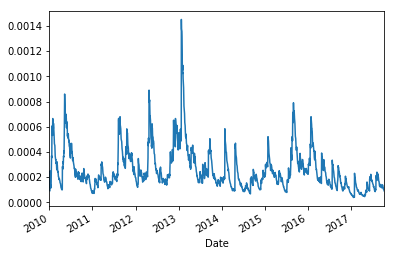

In [4]:
sig=myewm.var(bias=False)
import matplotlib.pyplot as plt
%matplotlib inline
sig.plot()


# Plotting